# News topic

## basic code

In [1]:
import tensorflow as tf

In [3]:
epochs = 20
batch_size = 512
lr = 1e-3

In [2]:
import numpy as np
print(np.__version__)

1.16.1


In [4]:
a = tf.keras.datasets.reuters.load_data(num_words=10000)
print(type(a))

<class 'tuple'>


In [6]:
b, c = a
print(type(b), type(c))

<class 'tuple'> <class 'tuple'>


In [7]:
x_train, y_train_cls = b
x_test, y_test_cls = c
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(8982,) (8982,) (2246,) (2246,)


In [8]:
print(type(x_train[0]), type(x_test[0]))

<class 'list'> <class 'list'>


In [9]:
print(y_train_cls.min(), y_test_cls.min())

0 0


In [10]:
print(y_train_cls.max(), y_test_cls.max())

45 45


In [11]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [12]:
y_train_cls = y_train_cls.astype(np.int32) #원래 class가 numpy.int32면 굳이 바꿀 필요 없음....
y_test_cls = y_test_cls.astype(np.int32)
word2int = tf.keras.datasets.reuters.get_word_index(path='reuters_word_index.json')
int2word = dict([(value, key) for (key, value) in word2int.items()])
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

557056/550378 [==============================] - 0s 1us/step
(8982,) (8982,) (2246,) (2246,)


In [13]:
print(type(y_test_cls[0]))

<class 'numpy.int32'>


In [14]:
print(' '.join([int2word.get(i - 3, '?') for i in x_train[0]])) #-3은 .. 뭘가
print(y_train_cls[0])

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
3


In [15]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  
    return results
x_train = vectorize_sequences(x_train) 
x_test = vectorize_sequences(x_test) 
print(x_train.shape, y_train_cls.shape, x_test.shape, y_test_cls.shape)

(8982, 10000) (8982,) (2246, 10000) (2246,)


In [16]:
y_train = np.squeeze(np.eye(46)[y_train_cls]).astype(np.int32)
y_test = np.squeeze(np.eye(46)[y_test_cls]).astype(np.int32)
print(x_train.shape, y_train.shape, y_train_cls.shape, x_test.shape, y_test.shape, y_test_cls.shape)

(8982, 10000) (8982, 46) (8982,) (2246, 10000) (2246, 46) (2246,)


In [17]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [18]:
x = tf.placeholder(tf.float32, (None, 10000)) 
y = tf.placeholder(tf.int32, (None, 46)) 
y_cls = tf.placeholder(tf.int32, (None,)) 

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

b1 = tf.get_variable('b1', (64,), tf.float32, init_b)
w1 = tf.get_variable('w1', (10000,64), tf.float32, init_w)

b2 = tf.get_variable('b2', (64,), tf.float32, init_b)
w2 = tf.get_variable('w2', (64,64), tf.float32, init_w)

b3 = tf.get_variable('b3', (46,), tf.float32, init_b)
w3 = tf.get_variable('w3', (64,46), tf.float32, init_w) #1이 아니라 46!

x1 = tf.nn.relu(x @ w1 + b1) 
x2 = tf.nn.relu(x1 @ w2 + b2) 
logits = x2 @ w3 + b3
y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) #sigmoid가 아닌 softmax! 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y_cls, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
def shuffle_batch(x, y, y_cls, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx], y_cls[batch_idx]

In [20]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        for x_batch, y_batch, y_batch_cls in shuffle_batch(x_train, y_train, y_train_cls, batch_size):
            feed_dict = {x: x_batch, y: y_batch, y_cls: y_batch_cls}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y: y_test, y_cls: y_test_cls}
    accuracy_run, y_test_pred_cls = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/20 
epoch 1/20 
epoch 2/20 
epoch 3/20 
epoch 4/20 
epoch 5/20 
epoch 6/20 
epoch 7/20 
epoch 8/20 
epoch 9/20 
epoch 10/20 
epoch 11/20 
epoch 12/20 
epoch 13/20 
epoch 14/20 
epoch 15/20 
epoch 16/20 
epoch 17/20 
epoch 18/20 
epoch 19/20 

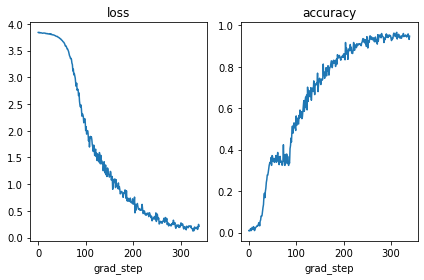

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [22]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.7960819


## keras code

In [23]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

In [26]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [27]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 175us/step - loss: 2.6758 - accuracy: 0.5303 - val_loss: 1.7202 - val_accuracy: 0.6420
Epoch 2/20
7982/7982 [==============================] - 1s 132us/step - loss: 1.4102 - accuracy: 0.7116 - val_loss: 1.2942 - val_accuracy: 0.7220
Epoch 3/20
7982/7982 [==============================] - 1s 163us/step - loss: 1.0431 - accuracy: 0.7835 - val_loss: 1.1339 - val_accuracy: 0.7560
Epoch 4/20
7982/7982 [==============================] - 1s 139us/step - loss: 0.8186 - accuracy: 0.8330 - val_loss: 1.0357 - val_accuracy: 0.7970
Epoch 5/20
7982/7982 [==============================] - 1s 123us/step - loss: 0.6563 - accuracy: 0.8654 - val_loss: 0.9863 - val_accuracy: 0.7860
Epoch 6/20
7982/7982 [==============================] - 1s 126us/step - loss: 0.5263 - accuracy: 0.8905 - val_loss: 0.9716 - val_accuracy: 0.7800
Epoch 7/20
7982/7982 [==============================] - 1s 123us/step - los

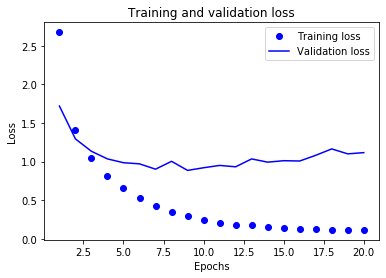

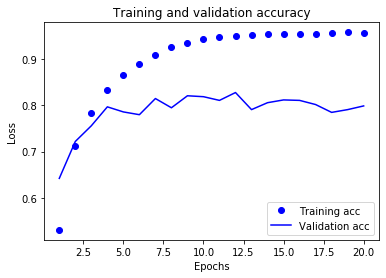

In [28]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [29]:
results = model.evaluate(x_test, y_test)
print(results)

2246/2246 [==============================] - 0s 185us/step
[1.2555133411105148, 0.7831701040267944]


In [30]:
model.predict(x_test)

array([[1.8215474e-05, 1.5119128e-05, 5.8332614e-07, ..., 5.3792047e-07,
        3.9588869e-07, 2.1432360e-08],
       [3.2197134e-04, 8.2894890e-03, 1.6050844e-05, ..., 9.8438313e-10,
        1.8186946e-09, 2.4153053e-09],
       [1.0993289e-03, 9.7944105e-01, 2.4316695e-03, ..., 1.1198513e-06,
        4.2236475e-06, 1.3975518e-04],
       ...,
       [1.2019016e-06, 5.0587951e-06, 9.3454690e-07, ..., 5.9509759e-08,
        4.5447052e-08, 4.6836249e-08],
       [2.1075420e-03, 2.5100109e-01, 1.2006557e-03, ..., 4.7779671e-04,
        4.0582908e-04, 5.2556436e-05],
       [9.0819900e-05, 9.8375779e-01, 1.1312205e-03, ..., 5.7833557e-07,
        1.2069136e-06, 1.6650380e-05]], dtype=float32)

## Mix

In [31]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [32]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation=None))

x = model.input
y = tf.placeholder(tf.int32, (None, 46)) 
y_cls = tf.placeholder(tf.int32, (None,)) 
 
logits = model.output
y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y_cls, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

이하는 basic code와 같음...

accuracy도 basic code랑 같은 듯

# House price

In [18]:
import numpy as np

x_train = np.array([848, 960, 1563, 910, 1440, 1944, 904, 936, 912]).reshape((-1,1)).astype(np.float32)
y_train = np.array([272, 313, 342, 325, 291, 351, 294, 367, 279]).reshape((-1,1)).astype(np.float32)
mu = x_train.mean()
sigma = x_train.std()
x_train = (x_train - x_train.mean()) / x_train.std()

x_test = np.array([1650]).reshape((-1,1)).astype(np.float32)
y_test = np.array([335]).reshape((-1,1)).astype(np.float32)
x_test = (x_test - mu) / sigma

In [19]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(9, 1) (9, 1) (1, 1) (1, 1)


In [20]:
lr = 5e-3
epoch = int(1e5)

In [21]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 1))
y = tf.placeholder(tf.float32, (None, 1))

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

b = tf.get_variable('b', (1,), tf.float32, init_b)
w = tf.get_variable('w', (1,1), tf.float32, init_w)

y_pred = x @ w + b
error = y - y_pred
loss = tf.nn.l2_loss(error)
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

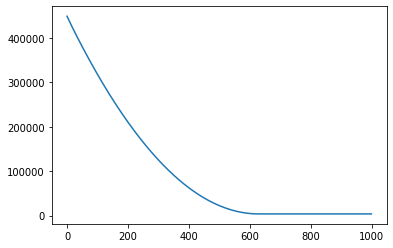

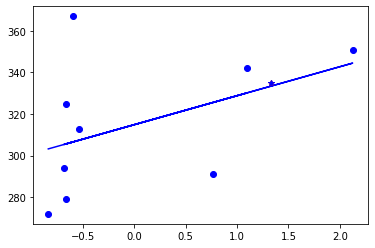

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session() as sess :
    sess.run(init)
    
    loss_trace = []
    for i in range(epoch) :
        feed_dict = {x:x_train, y:y_train}
        if i % 100 == 99 :            
            _, loss_run = sess.run([train, loss], feed_dict=feed_dict)
            loss_trace.append(loss_run)
        else :
            sess.run(train, feed_dict=feed_dict)

    feed_dict = {x:x_train}
    y_train_pred = sess.run(y_pred, feed_dict=feed_dict)

    feed_dict = {x:x_test}
    y_test_pred_final = sess.run(y_pred, feed_dict = feed_dict)

plt.plot(loss_trace)
plt.show()

plt.plot(x_train, y_train, 'ob')
plt.plot(x_train, y_train_pred, '-b')
plt.plot(x_test[0,0], y_test[0,0], '*r')
plt.plot(x_test, y_test, '*b')
plt.show()


## Learning Rate

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def f(x):
    return x ** 2


def gradient(x):
    return 2 * x


def grdient_descent(x0=1, lr=0.1, epoch=10):
    history_x = [x0]
    history_y = [f(x0)]
    for i in range(epoch):
        x0 -= lr * gradient(x0)
        history_x.append(x0)
        history_y.append(f(x0))
    return history_x, history_y

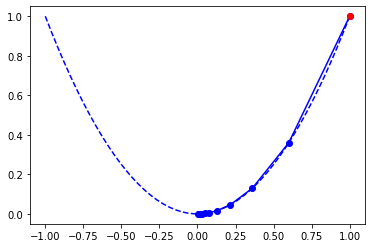

In [25]:
def plot_grdient_descent(history_x, history_y):
    x_max = np.max(np.abs(history_x))
    x_plot = np.linspace(-x_max, x_max)  
    y_plot = f(x_plot)
    plt.plot(x_plot, y_plot, '--b')
    plt.plot(history_x, history_y, 'o-b')
    plt.plot(history_x[0], history_y[0], 'o-r')
    plt.show()


if __name__ == '__main__':
    x0 = 1
    lr = 0.2
    epoch = 10

    history_x, history_y = grdient_descent(x0=x0, lr=lr, epoch=epoch)
    plot_grdient_descent(history_x, history_y)

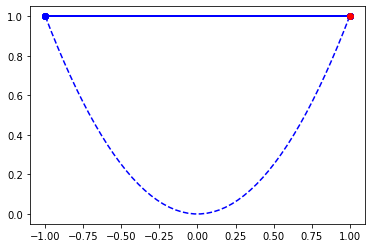

In [26]:
def plot_grdient_descent(history_x, history_y):
    x_max = np.max(np.abs(history_x))
    x_plot = np.linspace(-x_max, x_max)  
    y_plot = f(x_plot)
    plt.plot(x_plot, y_plot, '--b')
    plt.plot(history_x, history_y, 'o-b')
    plt.plot(history_x[0], history_y[0], 'o-r')
    plt.show()


if __name__ == '__main__':
    x0 = 1
    lr = 1
    epoch = 10

    history_x, history_y = grdient_descent(x0=x0, lr=lr, epoch=epoch)
    plot_grdient_descent(history_x, history_y)

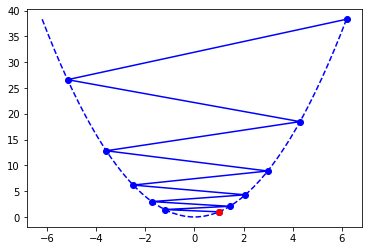

In [27]:
def plot_grdient_descent(history_x, history_y):
    x_max = np.max(np.abs(history_x))
    x_plot = np.linspace(-x_max, x_max)  
    y_plot = f(x_plot)
    plt.plot(x_plot, y_plot, '--b')
    plt.plot(history_x, history_y, 'o-b')
    plt.plot(history_x[0], history_y[0], 'o-r')
    plt.show()


if __name__ == '__main__':
    x0 = 1
    lr = 1.1
    epoch = 10

    history_x, history_y = grdient_descent(x0=x0, lr=lr, epoch=epoch)
    plot_grdient_descent(history_x, history_y)

발산해버렷!

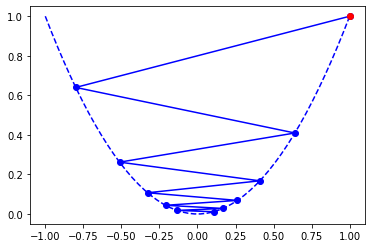

In [28]:
def plot_grdient_descent(history_x, history_y):
    x_max = np.max(np.abs(history_x))
    x_plot = np.linspace(-x_max, x_max)  
    y_plot = f(x_plot)
    plt.plot(x_plot, y_plot, '--b')
    plt.plot(history_x, history_y, 'o-b')
    plt.plot(history_x[0], history_y[0], 'o-r')
    plt.show()


if __name__ == '__main__':
    x0 = 1
    lr = 0.9
    epoch = 10

    history_x, history_y = grdient_descent(x0=x0, lr=lr, epoch=epoch)
    plot_grdient_descent(history_x, history_y)

이거도 별로 좋지는 않음...

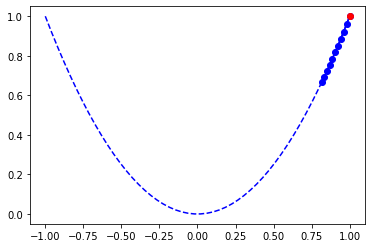

In [30]:
def plot_grdient_descent(history_x, history_y):
    x_max = np.max(np.abs(history_x))
    x_plot = np.linspace(-x_max, x_max)  
    y_plot = f(x_plot)
    plt.plot(x_plot, y_plot, '--b')
    plt.plot(history_x, history_y, 'o-b')
    plt.plot(history_x[0], history_y[0], 'o-r')
    plt.show()


if __name__ == '__main__':
    x0 = 1
    lr = 0.01
    epoch = 10

    history_x, history_y = grdient_descent(x0=x0, lr=lr, epoch=epoch)
    plot_grdient_descent(history_x, history_y)

너무 천천히 내려감

## basic code

In [31]:
epochs = 400
def learning_rate(i):
    lr = 1e-1
    if i>= 300:
        lr = 1e-2
    if i>= 350:
        lr = 1e-3
    return lr

learning rate을 이런 식으로 다르게 둘 수도 있다!

In [32]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

57344/57026 [==============================] - 0s 1us/step
(404, 13) (404, 1) (102, 13) (102, 1)


In [33]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [34]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [35]:
x = tf.placeholder(tf.float32, (None, 13)) 
y = tf.placeholder(tf.float32, (None, 1))
lr = tf.placeholder(tf.float32, ())

init_b = tf.keras.initializers.constant(0.0)
init_w = tf.keras.initializers.VarianceScaling(mode='fan_avg')

b1 = tf.get_variable('b1', (1,), tf.float32, init_b)
w1 = tf.get_variable('w1', (13, 1), tf.float32, init_w)

y_pred = x @ w1 + b1
loss = tf.nn.l2_loss(y-y_pred) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []

    for i in range(epochs):
        print()
        print('epoch {}/{}'.format(i, epochs), end=' ')
        feed_dict = {x: x_train, y: y_train, lr: learning_rate(i)}
        loss_run, _ = sess.run([loss, train], feed_dict=feed_dict)
        loss_trace.append(loss_run)

    feed_dict = {x: x_test, y: y_test}
    loss_test_run = sess.run(loss, feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/400 
epoch 1/400 
epoch 2/400 
epoch 3/400 
epoch 4/400 
epoch 5/400 
epoch 6/400 
epoch 7/400 
epoch 8/400 
epoch 9/400 
epoch 10/400 
epoch 11/400 
epoch 12/400 
epoch 13/400 
epoch 14/400 
epoch 15/400 
epoch 16/400 
epoch 17/400 
epoch 18/400 
epoch 19/400 
epoch 20/400 
epoch 21/400 
epoch 22/400 
epoch 23/400 
epoch 24/400 
epoch 25/400 
epoch 26/400 
epoch 27/400 
epoch 28/400 
epoch 29/400 
epoch 30/400 
epoch 31/400 
epoch 32/400 
epoch 33/400 
epoch 34/400 
epoch 35/400 
epoch 36/400 
epoch 37/400 
epoch 38/400 
epoch 39/400 
epoch 40/400 
epoch 41/400 
epoch 42/400 
epoch 43/400 
epoch 44/400 
epoch 45/400 
epoch 46/400 
epoch 47/400 
epoch 48/400 
epoch 49/400 
epoch 50/400 
epoch 51/400 
epoch 52/400 
epoch 53/400 
epoch 54/400 
epoch 55/400 
epoch 56/400 
epoch 57/400 
epoch 58/400 
epoch 59/400 
epoch 60/400 
epoch 61/400 
epoch 62/400 
epoch 63/400 
epoch 64/400 
epoch 65/400 
epoch 66/400 
epoch 67/400 
epoch 68/400 
epoch 69/400 
epoch 70/400 
epoch 71/400 
e

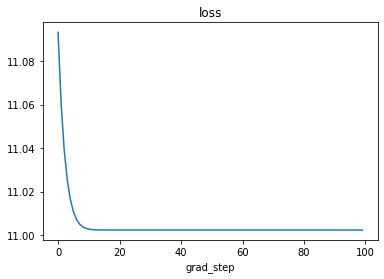

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.array(loss_trace[300:])/404)
ax.set_title('loss')
ax.set_xlabel('grad_step')
plt.show()

In [38]:
print('Test L2 Loss :', loss_test_run/102)

Test L2 Loss : 11.597895603553921


## keras code

In [39]:
epochs = 500
batch_size = 1
lr = 1e-3

In [40]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [41]:
def build_model():
    from keras import models
    from keras import layers
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [42]:
import numpy as np

k = 4
num_val_samples = len(x_train) // k
mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    mae_histories.append(mae_history)
    print(tf.get_default_graph())

processing fold # 0


Using TensorFlow backend.



processing fold # 1
processing fold # 2
processing fold # 3


In [43]:
average_mae_histories = [
    np.mean([x[i] for x in mae_histories]) for i in range(epochs)]

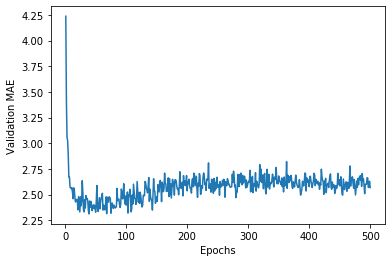

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_histories) + 1), average_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

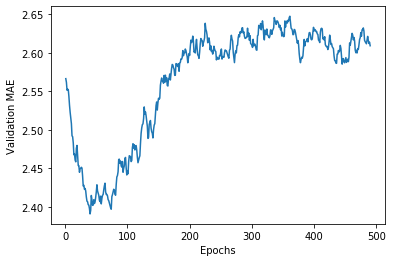

In [45]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_histories = smooth_curve(average_mae_histories[10:])

plt.plot(range(1, len(smooth_mae_histories) + 1), smooth_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [46]:
model = build_model()
model.fit(x_train, y_train,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

102/102 [==============================] - 0s 313us/step


In [47]:
test_mae_score

2.832794189453125

mix code는 안 짜셨대 ㅎ